In [3]:
!pip install nltk keybert sentence-transformers vaderSentiment --quiet

import os
import json
import pandas as pd
from keybert import KeyBERT
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
review_folder = "/content/drive/MyDrive/auto_analyst_data/parsed/reviews"
output_folder = "/content/drive/MyDrive/auto_analyst_data/parsed/processed"
os.makedirs(output_folder, exist_ok=True)

companies = [f[:-5] for f in os.listdir(review_folder) if f.endswith(".json")]
print(f"✅ Found {len(companies)} companies.")


✅ Found 1 companies.


# Keyword + Sentiment Engine

In [3]:
analyzer = SentimentIntensityAnalyzer()
kw_model = KeyBERT()

def process_review(text):
    sentiment = analyzer.polarity_scores(text)['compound']
    keywords = kw_model.extract_keywords(text, top_n=3, stop_words='english')
    return sentiment, [kw[0] for kw in keywords]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda


In [5]:
for company in tqdm(companies[:10]):  # Remove [:10] to process all
    path = os.path.join(review_folder, f"{company}.json")
    with open(path) as f:
        reviews = json.load(f)

    enriched = []
    for r in reviews:
        text = r.get('content', '') or ''
        sentiment, keywords = process_review(text)
        enriched.append({
            "title": r.get("title", ""),
            "content": text,
            "sentiment": sentiment,
            "keywords": keywords
        })

    # Save
    out_path = os.path.join(output_folder, f"{company}.json")
    with open(out_path, "w") as f:
        json.dump(enriched, f, indent=2)


100%|██████████| 1/1 [05:41<00:00, 341.22s/it]


In [5]:
df = pd.read_json('/content/drive/MyDrive/auto_analyst_data/parsed/processed/Google.json')

In [6]:
df.head()

,title,content,sentiment,keywords
0,Software Engineer,Pros: I work w/ a diverse set of people. You h...,0.6858,"[pros, micromanagement, freedom]"
1,Software Engineer,Pros: People are willing to share knowledge wh...,0.8176,"[pros, industry, cons]"
2,Software Engineer,"Pros: To repeat what I wrote before, the peopl...",0.7233,"[pros, cons, company]"
3,Software Engineer,"Pros: To repeat what I wrote before, the peopl...",0.7233,"[pros, cons, company]"
4,Software Engineer,Pros: The name recognition that goes along w/ ...,0.3832,"[engineers, pros, cons]"


In [7]:
import pandas as pd

path = "/content/drive/MyDrive/auto_analyst_data/parsed/processed/Google.json"
df = pd.read_json(path)

df["date_review"] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))  # fake timeline for now
df["sentiment_score"] = df["sentiment"].astype(float)
df.head()


,title,content,sentiment,keywords,date_review,sentiment_score
0,Software Engineer,Pros: I work w/ a diverse set of people. You h...,0.6858,"[pros, micromanagement, freedom]",1981-06-30 05:26:31.733649,0.6858
1,Software Engineer,Pros: People are willing to share knowledge wh...,0.8176,"[pros, industry, cons]",1981-07-01 05:26:31.733649,0.8176
2,Software Engineer,"Pros: To repeat what I wrote before, the peopl...",0.7233,"[pros, cons, company]",1981-07-02 05:26:31.733649,0.7233
3,Software Engineer,"Pros: To repeat what I wrote before, the peopl...",0.7233,"[pros, cons, company]",1981-07-03 05:26:31.733649,0.7233
4,Software Engineer,Pros: The name recognition that goes along w/ ...,0.3832,"[engineers, pros, cons]",1981-07-04 05:26:31.733649,0.3832


In [8]:
import plotly.express as px

monthly = df.resample("M", on="date_review")["sentiment_score"].mean().reset_index()

fig = px.line(monthly, x="date_review", y="sentiment_score",
              title="📈 Google Sentiment Over Time", markers=True)
fig.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



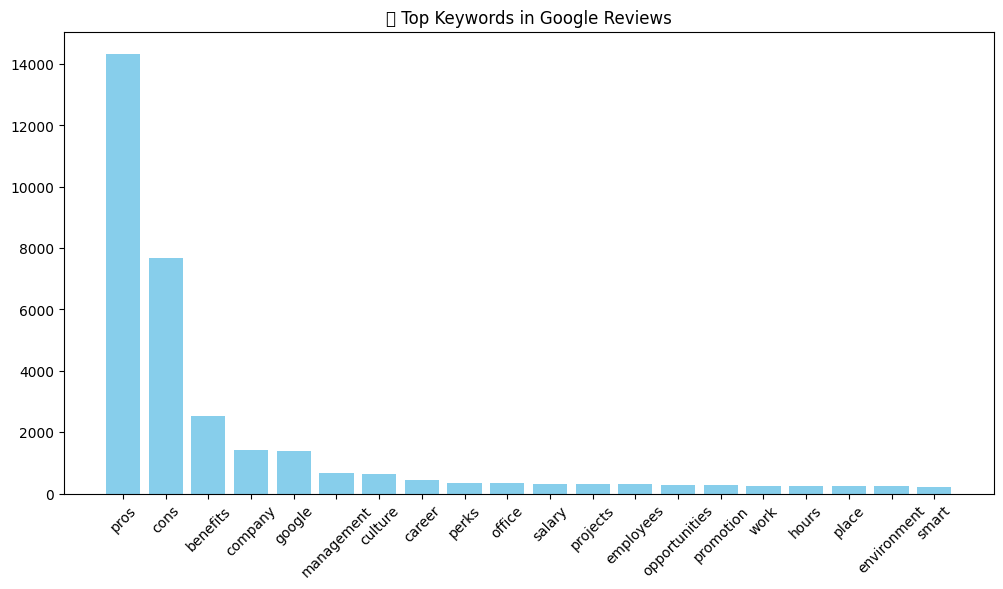

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

all_keywords = sum(df["keywords"].tolist(), [])
top_keywords = Counter(all_keywords).most_common(20)

labels, counts = zip(*top_keywords)
plt.figure(figsize=(12,6))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("🔍 Top Keywords in Google Reviews")
plt.show()


In [3]:
from huggingface_hub import login
login()


In [1]:
!pip install -q transformers accelerate bitsandbytes sentencepiece

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

model_id = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


In [2]:
def tag_review(review, pipe):
    categories = [
        "Work-Life Balance", "Compensation", "Leadership", "Learning and Growth",
        "Team Culture", "Work Environment", "Job Role Clarity", "Career Development"
    ]

    prompt = f"""Classify the following employee review into relevant categories from this list:
{categories}

Review:
"{review}"

Output format (JSON):
{{"tags": ["tag1", "tag2", ...]}}"""

    result = pipe(prompt)[0]["generated_text"]

    # Extract JSON-like part
    try:
        import re, json
        json_part = re.search(r"\{.*\}", result, re.DOTALL).group(0)
        tags = json.loads(json_part)["tags"]
    except:
        tags = []

    return tags


In [4]:
import json
from transformers import pipeline

# Load the 3 reviews
with open("/content/drive/MyDrive/auto_analyst_data/parsed/processed/Google.json") as f:
    reviews = json.load(f)

# Select the first 3 reviews
samples = reviews[:3]

# Process the first 3 reviews
for i, review in enumerate(samples):
    tags = tag_review(review['content'], pipe)
    print(f"\nReview {i+1} Title: {review['title']}")
    print(f"Tags: {tags}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Review 1 Title:  Software Engineer
Tags: []


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Review 2 Title:  Software Engineer
Tags: []

Review 3 Title:  Software Engineer
Tags: []


In [5]:
from transformers import pipeline

# Load the DistilGPT-2 model for text generation (lighter model)
pipe = pipeline("text-generation", model="distilgpt2", device=0)

def tag_review(review, pipe):
    categories = [
        "Work-Life Balance", "Compensation", "Leadership", "Learning and Growth",
        "Team Culture", "Work Environment", "Job Role Clarity", "Career Development"
    ]

    prompt = f"""
Classify the following review into relevant categories from this list:
{categories}

Review:
{review}

Please return only the categories as a JSON object, e.g., {{"tags": ["Work-Life Balance", "Compensation"]}}.
"""

    result = pipe(prompt, max_length=200, num_return_sequences=1)[0]["generated_text"]

    # Extract the tags from the generated output
    try:
        import re, json
        json_part = re.search(r"\{.*\}", result, re.DOTALL).group(0)
        tags = json.loads(json_part)["tags"]
    except:
        tags = []

    return tags

# Load the 3 reviews
with open("/content/drive/MyDrive/auto_analyst_data/parsed/processed/Google.json") as f:
    reviews = json.load(f)

# Select the first 3 reviews
samples = reviews[:3]

# Process the first 3 reviews
for i, review in enumerate(samples):
    tags = tag_review(review['content'], pipe)
    print(f"\nReview {i+1} Title: {review['title']}")
    print(f"Tags: {tags}")


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Review 1 Title:  Software Engineer
Tags: ['Work-Life Balance', 'Compensation']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Review 2 Title:  Software Engineer
Tags: ['Work-Life Balance', 'Compensation']

Review 3 Title:  Software Engineer
Tags: ['Work-Life Balance', 'Compensation']
